In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

import os, sys
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

In [2]:
# Load performance records
perf_records = modules.utils.load_perf_logs('../perflogs', 'Gromacs', '.log')
print('loaded %s performance records' % len(perf_records))

loaded 180 performance records


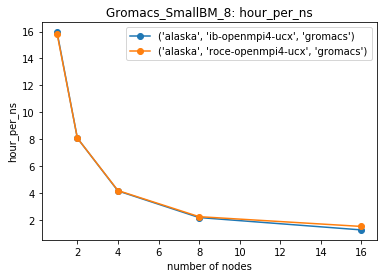

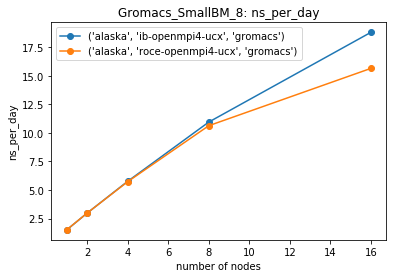

In [3]:
# Plot comparisons across number of nodes for most-recent test per system/partition/environment:

# perf-var:
#  xs: n_cores, ys: value, s: SPE
for perf_var, data in perf_records.groupby('perf_var'):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for spe, data in data.groupby(['sysname', 'partition', 'environ']):
        xs = []
        ys = []
        for test, data in data.groupby('testname'): # NB this won't iterate in number-of-cores order!
            n_nodes = int(test.rsplit('_')[-1]) # TODO: be better if we could get this into the perflog tbh
            xs.append(n_nodes)
            last_test = data.iloc[-1] # as we know performance logs go forward thro history
            ys.append(last_test['perf_value'])
            # now sort by number of nodes:
        xs, ys = zip(*sorted(zip(xs, ys), key=lambda xy: xy[0]))
        plt.plot(xs, ys, 'o-', label=spe)
        ax.set_title('%s: %s' % (test, perf_var))
        ax.legend()
        ax.grid()
        ax.set_xlabel('number of nodes')
        ax.set_ylabel(perf_var)
        

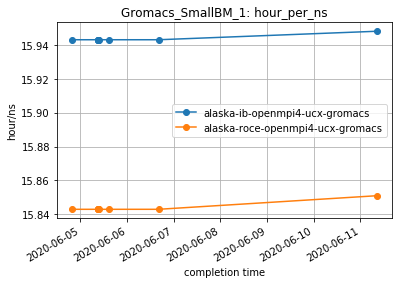

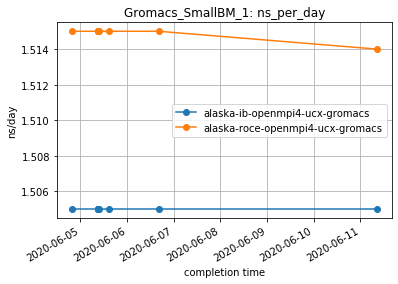

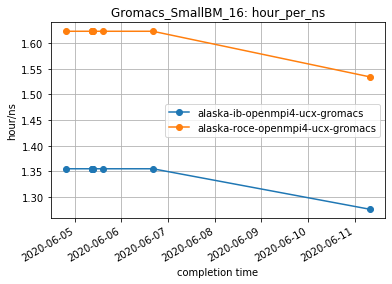

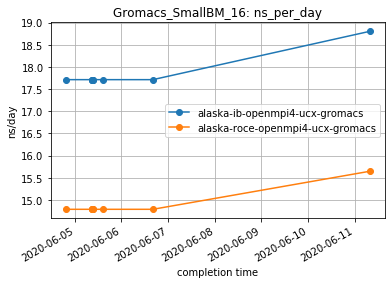

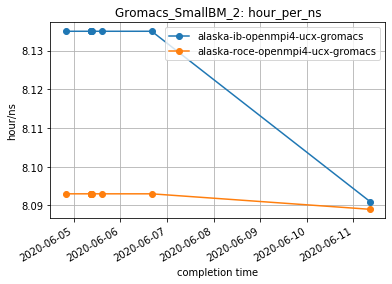

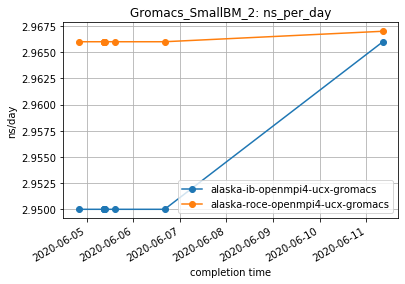

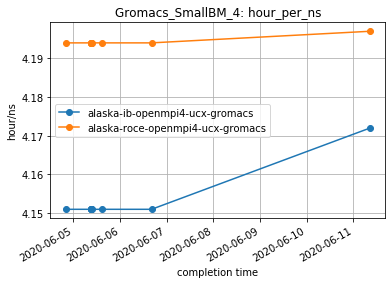

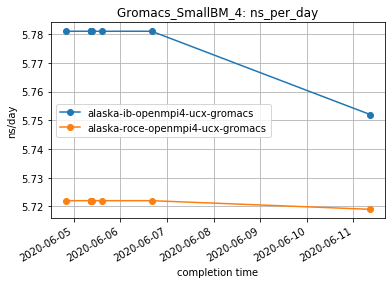

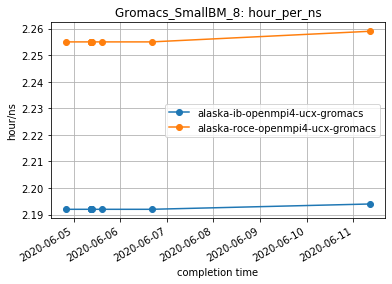

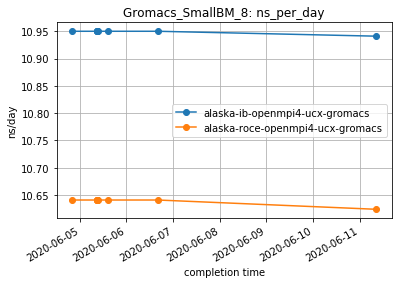

In [4]:
# Plot performance history:
modules.plots.plot_perf_history(perf_records)